# Urban Drone Demo

```
Copyright © 2024, United States Government, as represented by the Administrator of the National Aeronautics and Space Administration. All rights reserved.

The “"Fault Model Design tools - fmdtools version 2"” software is licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0. 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```

In [1]:
import fmdtools.sim.propagate as propagate
from fmdtools.analyze import tabulate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

## Model Overview
The drone model is defined in `drone_mdl_urban.py`, along with some visualization functions.

In [2]:
from drone_mdl_urban import Drone

In [3]:
mdl = Drone()

This is the model structure:

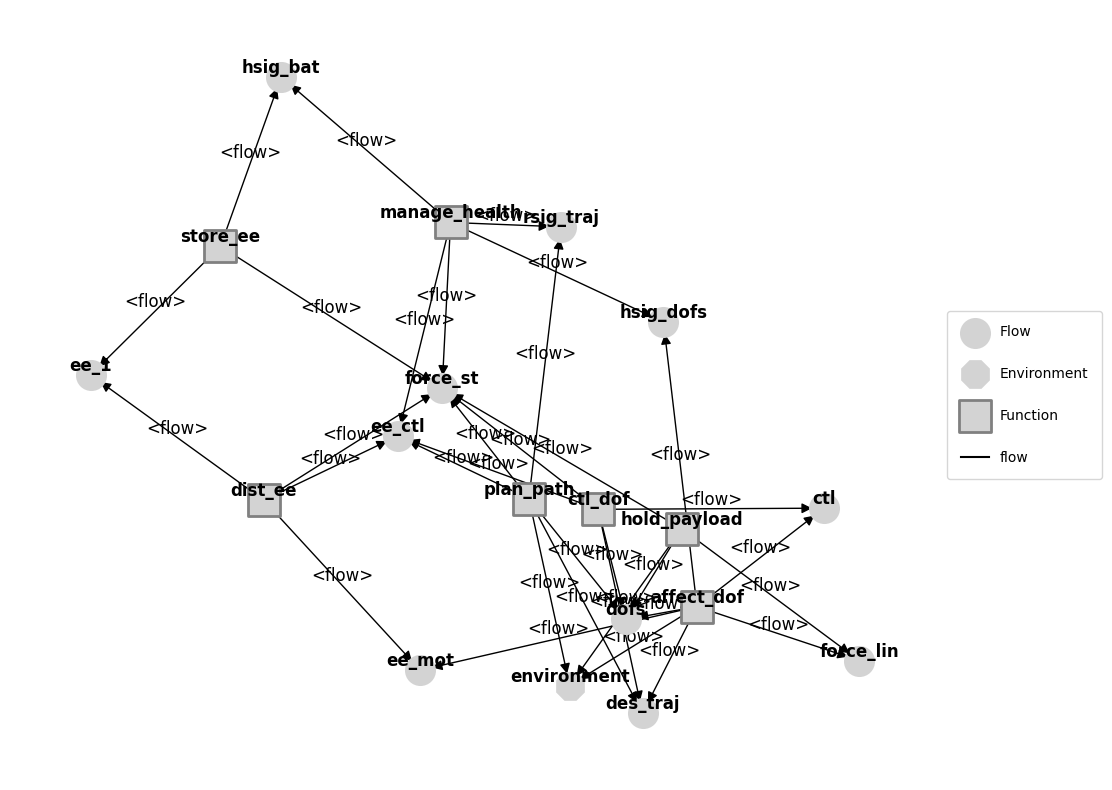

In [4]:
mg = mdl.as_modelgraph()
fig, ax = mg.draw()

We can also view the grid environment using its `show` methods:

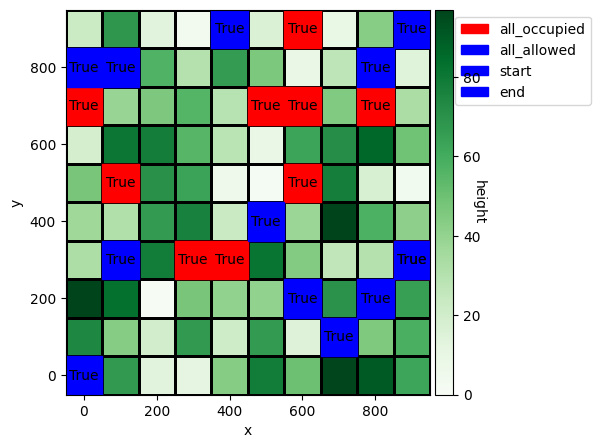

In [5]:
collections={"all_occupied": {"color": "red"}, "all_allowed": {"color": "blue"}, "start": {"color": "blue"}, "end": {"color": "blue"}}
fig, ax = mdl.flows['environment'].c.show({"height": {}}, collections=collections)

Which shows the Start, End, and allowed/unsafe locations in the 1000x1000-m grid. In this display, line thickness corresponds to building height, and hatching corresponds to whether or not the space is occupied. We can also display this using `show.coord3d`:

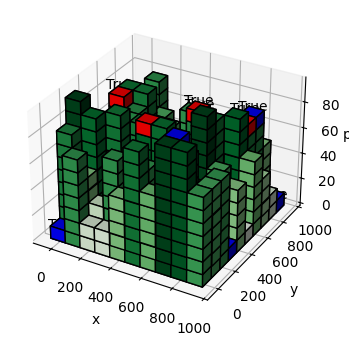

In [6]:
fig, ax = mdl.flows['environment'].c.show_z("height", collections=collections)

## Nominal Simulation

Below we show how this drone performs in the nominal scenario.

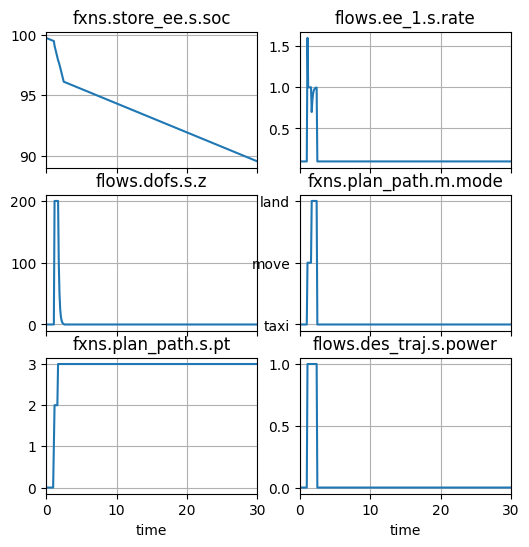

In [7]:
results_nom, hist_nom =propagate.nominal(mdl)
fig, axs = hist_nom.plot_line("fxns.store_ee.s.soc",
                            'flows.ee_1.s.rate',
                            'flows.dofs.s.z',
                            'fxns.plan_path.m.mode',
                            'fxns.plan_path.s.pt',
                            'flows.des_traj.s.power')

As shown, the flight ends fairly quickly (in 10 minutes), with the drone successively proceeding through points in the flight plan.

We can also view this flightpath in 3-d space using `History.plot_trajectories`:

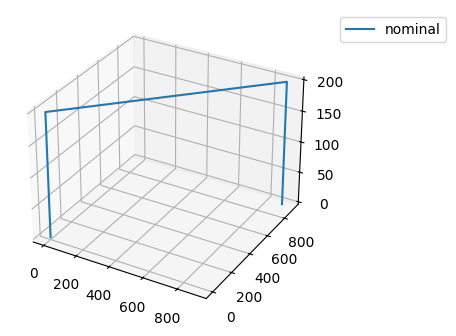

In [8]:
fig, ax = hist_nom.plot_trajectories('dofs.s.x', 'dofs.s.y', 'dofs.s.z')

Trajectory plots can be overlaid on top of environment plots. In this case, we defined the method `plot_env_with_traj` and `plot_env_with_traj_z` for this case.

In [9]:
from drone_mdl_urban import plot_env_with_traj, plot_env_with_traj_z


(<Figure size 400x400 with 1 Axes>,
 <Axes3D: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

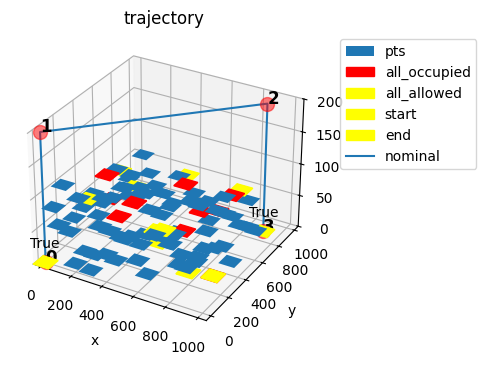

In [10]:
plot_env_with_traj_z(hist_nom, mdl)

(<Figure size 500x500 with 2 Axes>,
 <Axes: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

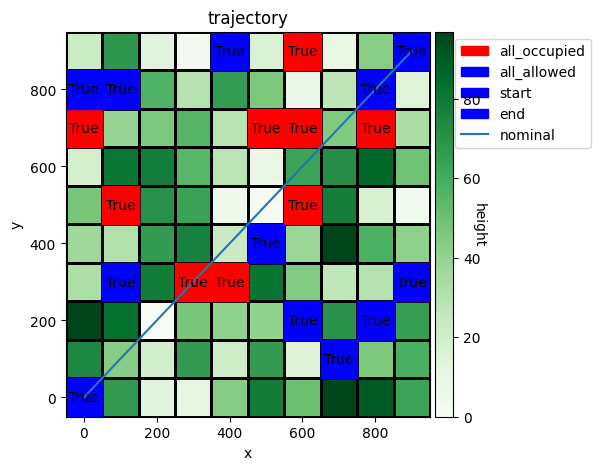

In [11]:
plot_env_with_traj(hist_nom, mdl)

As shown, this is a rather simple straight-line path. If we wanted a more complex scenario, we could make the path more complex by adding multiple destinations or planning the path based on allowed flight/landing locations.

As it is, we may also want to adjust the timestep/speed to get more resolution, since the drone only has a few discrete timesteps in the air.

The results for the simulation are:

In [12]:
results_nom

endclass: 
--rate:                              1.0
--cost:                              0.0
--expected_cost:                     0.0
--repcost:                             0
--unsafe_flight_time:                  0
--body_strikes:                      0.0
--head_strikes:                      0.0
--property_restrictions:               0
--safecost:                          0.0
--landcost:                            0
--p_safety:                          0.0
--severities: {'hazardous': 0.0, 'minor': 1.0}

## Resilience model
A number of different faults have been implemented in the system.

For example, here we inject a mechanical fault in the left-rear rotor during flight:

In [13]:
mdl.fxns['affect_dof'].m.faultmodes

{'lf_short': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lf_openc': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lf_ctlup': Fault(prob=2.0000000000000003e-06, cost=500, phases={}, units='sim'),
 'lf_ctldn': Fault(prob=2.0000000000000003e-06, cost=500, phases={}, units='sim'),
 'lf_ctlbreak': Fault(prob=2.0000000000000003e-06, cost=1000, phases={}, units='sim'),
 'lf_mechbreak': Fault(prob=1.0000000000000002e-06, cost=500, phases={}, units='sim'),
 'lf_mechfriction': Fault(prob=5.000000000000001e-07, cost=500, phases={}, units='sim'),
 'lf_propwarp': Fault(prob=1.0000000000000001e-07, cost=200, phases={}, units='sim'),
 'lf_propstuck': Fault(prob=2.0000000000000002e-07, cost=200, phases={}, units='sim'),
 'lf_propbreak': Fault(prob=3.0000000000000004e-07, cost=200, phases={}, units='sim'),
 'lr_short': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lr_openc': Fault(prob=1.0000000000000002e-06, cost=200, phas

In [14]:
results_fault, hist_fault =propagate.one_fault(mdl, "affect_dof", "lr_mechbreak", time=2.0)

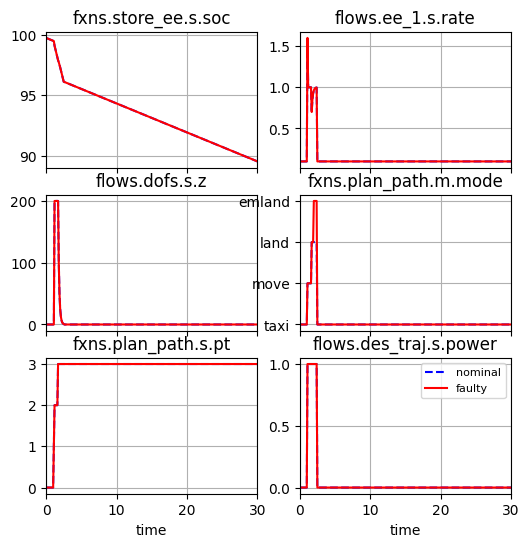

In [15]:
fig, axs = hist_fault.plot_line("fxns.store_ee.s.soc",
                                'flows.ee_1.s.rate',
                                'flows.dofs.s.z',
                                'fxns.plan_path.m.mode',
                                'fxns.plan_path.s.pt',
                                'flows.des_traj.s.power')

(<Figure size 400x400 with 1 Axes>,
 <Axes3D: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

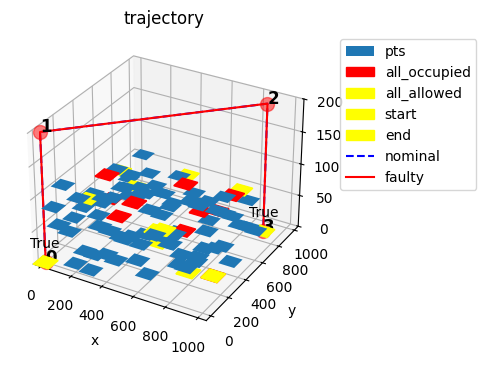

In [16]:
plot_env_with_traj_z(hist_fault, mdl)

(<Figure size 500x500 with 2 Axes>,
 <Axes: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

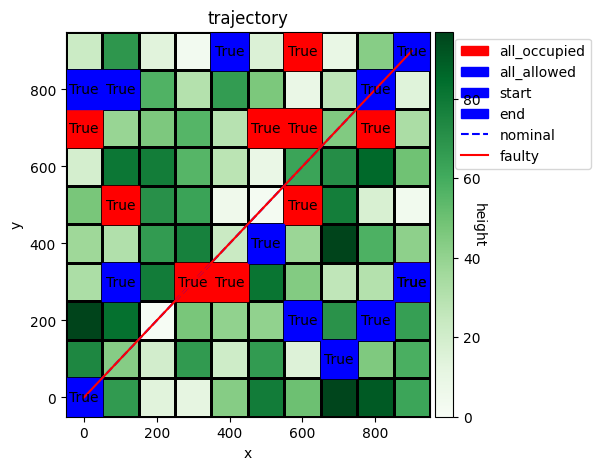

In [17]:
plot_env_with_traj(hist_fault, mdl)

In [18]:
results_fault

endclass.rate:    1.0000000000000002e-06
endclass.cost:                   28600.0
endclass.expected_cost: 2860.0000000000005
endclass.repcost:                    500
endclass.unsafe_flight_time:         281
endclass.body_strikes:               0.0
endclass.head_strikes:               0.0
endclass.property_restrictions:        0
endclass.safecost:               28100.0
endclass.landcost:                     0
endclass.p_safety:                   0.0
endclass.severities: {'hazardous': 0.0, 'minor': 1.0000000000000002e-06}

Here we inject a large list of faults in the system and evaluate their relative consequences in terms of metrics calculated in find_classification:

In [19]:
from fmdtools.analyze.phases import PhaseMap, from_hist
phasemaps = from_hist(hist_nom, fxn_modephases=[])
phasemaps

{'ctl_dof': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'plan_path': PhaseMap({'taxi': [0.0, 1.0], 'move': [1.1, 1.6], 'land': [1.7, 2.4], 'taxi1': [2.5, 30.0]}, {})}

In [20]:
from drone_mdl_urban import make_move_quad
move_quad=make_move_quad(hist_nom, phasemaps['plan_path'].phases['move'])
move_quad

{'samp': 'quadrature',
 'quad': {'nodes': [-0.20000000000000018, 1.0], 'weights': [1.0, 0.92]}}

In [21]:
from fmdtools.sim.sample import FaultDomain, FaultSample


fd = FaultDomain(mdl)
fd.add_all()

fs = FaultSample(fd, phasemap = phasemaps['plan_path'])
fs.add_fault_phases("move", method = "quad",
                    args=(move_quad['quad']['nodes'], move_quad['quad']['weights']))

fs

FaultSample of scenarios: 
 - manage_health_lostfunction_t2
 - manage_health_lostfunction_t2
 - store_ee_nocharge_t2
 - store_ee_nocharge_t2
 - store_ee_lowcharge_t2
 - store_ee_lowcharge_t2
 - store_ee_s1p1_short_t2
 - store_ee_s1p1_short_t2
 - store_ee_s1p1_degr_t2
 - store_ee_s1p1_degr_t2
 - ... (118 total)

In [22]:
endresults, hists = propagate.fault_sample(mdl, fs, staged=False)

SCENARIOS COMPLETE:   0%|          | 0/118 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   1%|          | 1/118 [00:01<03:31,  1.81s/it]

SCENARIOS COMPLETE:   2%|▏         | 2/118 [00:03<03:32,  1.84s/it]

SCENARIOS COMPLETE:   3%|▎         | 3/118 [00:05<03:29,  1.82s/it]

SCENARIOS COMPLETE:   3%|▎         | 4/118 [00:07<03:26,  1.81s/it]

SCENARIOS COMPLETE:   4%|▍         | 5/118 [00:09<03:24,  1.81s/it]

SCENARIOS COMPLETE:   5%|▌         | 6/118 [00:10<03:22,  1.81s/it]

SCENARIOS COMPLETE:   6%|▌         | 7/118 [00:12<03:18,  1.79s/it]

SCENARIOS COMPLETE:   7%|▋         | 8/118 [00:14<03:16,  1.79s/it]

SCENARIOS COMPLETE:   8%|▊         | 9/118 [00:16<03:14,  1.78s/it]

SCENARIOS COMPLETE:   8%|▊         | 10/118 [00:17<03:12,  1.78s/it]

SCENARIOS COMPLETE:   9%|▉         | 11/118 [00:19<03:08,  1.76s/it]

SCENARIOS COMPLETE:  10%|█         | 12/118 [00:21<03:05,  1.75s/it]

SCENARIOS COMPLETE:  11%|█         | 13/118 [00:23<03:04,  1.76s/it]

SCENARIOS COMPLETE:  12%|█▏        | 14/118 [00:24<03:02,  1.76s/it]

SCENARIOS COMPLETE:  13%|█▎        | 15/118 [00:26<03:01,  1.76s/it]

SCENARIOS COMPLETE:  14%|█▎        | 16/118 [00:28<03:00,  1.77s/it]

SCENARIOS COMPLETE:  14%|█▍        | 17/118 [00:30<02:57,  1.76s/it]

SCENARIOS COMPLETE:  15%|█▌        | 18/118 [00:31<02:54,  1.74s/it]

SCENARIOS COMPLETE:  16%|█▌        | 19/118 [00:33<02:54,  1.76s/it]

SCENARIOS COMPLETE:  17%|█▋        | 20/118 [00:35<02:51,  1.75s/it]

SCENARIOS COMPLETE:  18%|█▊        | 21/118 [00:37<02:50,  1.75s/it]

SCENARIOS COMPLETE:  19%|█▊        | 22/118 [00:38<02:48,  1.75s/it]

SCENARIOS COMPLETE:  19%|█▉        | 23/118 [00:40<02:47,  1.76s/it]

SCENARIOS COMPLETE:  20%|██        | 24/118 [00:42<02:46,  1.77s/it]

SCENARIOS COMPLETE:  21%|██        | 25/118 [00:44<02:45,  1.77s/it]

SCENARIOS COMPLETE:  22%|██▏       | 26/118 [00:46<02:43,  1.78s/it]

SCENARIOS COMPLETE:  23%|██▎       | 27/118 [00:47<02:41,  1.78s/it]

SCENARIOS COMPLETE:  24%|██▎       | 28/118 [00:49<02:40,  1.78s/it]

SCENARIOS COMPLETE:  25%|██▍       | 29/118 [00:51<02:39,  1.79s/it]

SCENARIOS COMPLETE:  25%|██▌       | 30/118 [00:53<02:36,  1.78s/it]

SCENARIOS COMPLETE:  26%|██▋       | 31/118 [00:54<02:34,  1.77s/it]

SCENARIOS COMPLETE:  27%|██▋       | 32/118 [00:56<02:32,  1.78s/it]

SCENARIOS COMPLETE:  28%|██▊       | 33/118 [00:58<02:30,  1.77s/it]

SCENARIOS COMPLETE:  29%|██▉       | 34/118 [01:00<02:29,  1.78s/it]

SCENARIOS COMPLETE:  30%|██▉       | 35/118 [01:02<02:28,  1.79s/it]

SCENARIOS COMPLETE:  31%|███       | 36/118 [01:03<02:26,  1.78s/it]

SCENARIOS COMPLETE:  31%|███▏      | 37/118 [01:05<02:23,  1.77s/it]

SCENARIOS COMPLETE:  32%|███▏      | 38/118 [01:07<02:20,  1.76s/it]

SCENARIOS COMPLETE:  33%|███▎      | 39/118 [01:09<02:18,  1.76s/it]

SCENARIOS COMPLETE:  34%|███▍      | 40/118 [01:10<02:16,  1.76s/it]

SCENARIOS COMPLETE:  35%|███▍      | 41/118 [01:12<02:15,  1.76s/it]

SCENARIOS COMPLETE:  36%|███▌      | 42/118 [01:14<02:13,  1.76s/it]

SCENARIOS COMPLETE:  36%|███▋      | 43/118 [01:16<02:12,  1.76s/it]

SCENARIOS COMPLETE:  37%|███▋      | 44/118 [01:17<02:11,  1.77s/it]

SCENARIOS COMPLETE:  38%|███▊      | 45/118 [01:19<02:09,  1.78s/it]

SCENARIOS COMPLETE:  39%|███▉      | 46/118 [01:21<02:07,  1.78s/it]

SCENARIOS COMPLETE:  40%|███▉      | 47/118 [01:23<02:06,  1.79s/it]

SCENARIOS COMPLETE:  41%|████      | 48/118 [01:25<02:04,  1.78s/it]

SCENARIOS COMPLETE:  42%|████▏     | 49/118 [01:26<02:02,  1.78s/it]

SCENARIOS COMPLETE:  42%|████▏     | 50/118 [01:28<02:00,  1.77s/it]

SCENARIOS COMPLETE:  43%|████▎     | 51/118 [01:30<01:59,  1.78s/it]

SCENARIOS COMPLETE:  44%|████▍     | 52/118 [01:32<01:57,  1.78s/it]

SCENARIOS COMPLETE:  45%|████▍     | 53/118 [01:34<01:55,  1.78s/it]

SCENARIOS COMPLETE:  46%|████▌     | 54/118 [01:35<01:53,  1.78s/it]

SCENARIOS COMPLETE:  47%|████▋     | 55/118 [01:37<01:52,  1.78s/it]

SCENARIOS COMPLETE:  47%|████▋     | 56/118 [01:39<01:51,  1.80s/it]

SCENARIOS COMPLETE:  48%|████▊     | 57/118 [01:41<01:49,  1.80s/it]

SCENARIOS COMPLETE:  49%|████▉     | 58/118 [01:43<01:48,  1.81s/it]

SCENARIOS COMPLETE:  50%|█████     | 59/118 [01:44<01:46,  1.80s/it]

SCENARIOS COMPLETE:  51%|█████     | 60/118 [01:46<01:44,  1.80s/it]

SCENARIOS COMPLETE:  52%|█████▏    | 61/118 [01:48<01:43,  1.81s/it]

SCENARIOS COMPLETE:  53%|█████▎    | 62/118 [01:50<01:42,  1.83s/it]

SCENARIOS COMPLETE:  53%|█████▎    | 63/118 [01:52<01:40,  1.82s/it]

SCENARIOS COMPLETE:  54%|█████▍    | 64/118 [01:53<01:38,  1.82s/it]

SCENARIOS COMPLETE:  55%|█████▌    | 65/118 [01:55<01:36,  1.82s/it]

SCENARIOS COMPLETE:  56%|█████▌    | 66/118 [01:57<01:34,  1.82s/it]

SCENARIOS COMPLETE:  57%|█████▋    | 67/118 [01:59<01:32,  1.82s/it]

SCENARIOS COMPLETE:  58%|█████▊    | 68/118 [02:01<01:32,  1.84s/it]

SCENARIOS COMPLETE:  58%|█████▊    | 69/118 [02:03<01:30,  1.84s/it]

SCENARIOS COMPLETE:  59%|█████▉    | 70/118 [02:04<01:27,  1.83s/it]

SCENARIOS COMPLETE:  60%|██████    | 71/118 [02:06<01:25,  1.81s/it]

SCENARIOS COMPLETE:  61%|██████    | 72/118 [02:08<01:22,  1.80s/it]

SCENARIOS COMPLETE:  62%|██████▏   | 73/118 [02:10<01:21,  1.81s/it]

SCENARIOS COMPLETE:  63%|██████▎   | 74/118 [02:12<01:19,  1.80s/it]

SCENARIOS COMPLETE:  64%|██████▎   | 75/118 [02:13<01:17,  1.79s/it]

SCENARIOS COMPLETE:  64%|██████▍   | 76/118 [02:15<01:15,  1.79s/it]

SCENARIOS COMPLETE:  65%|██████▌   | 77/118 [02:17<01:13,  1.79s/it]

SCENARIOS COMPLETE:  66%|██████▌   | 78/118 [02:19<01:11,  1.79s/it]

SCENARIOS COMPLETE:  67%|██████▋   | 79/118 [02:21<01:09,  1.79s/it]

SCENARIOS COMPLETE:  68%|██████▊   | 80/118 [02:22<01:07,  1.79s/it]

SCENARIOS COMPLETE:  69%|██████▊   | 81/118 [02:24<01:05,  1.78s/it]

SCENARIOS COMPLETE:  69%|██████▉   | 82/118 [02:26<01:04,  1.78s/it]

SCENARIOS COMPLETE:  70%|███████   | 83/118 [02:28<01:02,  1.78s/it]

SCENARIOS COMPLETE:  71%|███████   | 84/118 [02:29<01:00,  1.77s/it]

SCENARIOS COMPLETE:  72%|███████▏  | 85/118 [02:31<00:58,  1.77s/it]

SCENARIOS COMPLETE:  73%|███████▎  | 86/118 [02:33<00:56,  1.77s/it]

SCENARIOS COMPLETE:  74%|███████▎  | 87/118 [02:35<00:55,  1.77s/it]

SCENARIOS COMPLETE:  75%|███████▍  | 88/118 [02:36<00:52,  1.76s/it]

SCENARIOS COMPLETE:  75%|███████▌  | 89/118 [02:38<00:50,  1.75s/it]

SCENARIOS COMPLETE:  76%|███████▋  | 90/118 [02:40<00:48,  1.75s/it]

SCENARIOS COMPLETE:  77%|███████▋  | 91/118 [02:42<00:47,  1.75s/it]

SCENARIOS COMPLETE:  78%|███████▊  | 92/118 [02:43<00:45,  1.74s/it]

SCENARIOS COMPLETE:  79%|███████▉  | 93/118 [02:45<00:43,  1.74s/it]

SCENARIOS COMPLETE:  80%|███████▉  | 94/118 [02:47<00:41,  1.75s/it]

SCENARIOS COMPLETE:  81%|████████  | 95/118 [02:49<00:40,  1.76s/it]

SCENARIOS COMPLETE:  81%|████████▏ | 96/118 [02:50<00:38,  1.77s/it]

SCENARIOS COMPLETE:  82%|████████▏ | 97/118 [02:52<00:37,  1.78s/it]

SCENARIOS COMPLETE:  83%|████████▎ | 98/118 [02:54<00:35,  1.79s/it]

SCENARIOS COMPLETE:  84%|████████▍ | 99/118 [02:56<00:34,  1.80s/it]

SCENARIOS COMPLETE:  85%|████████▍ | 100/118 [02:58<00:32,  1.82s/it]

SCENARIOS COMPLETE:  86%|████████▌ | 101/118 [03:00<00:30,  1.80s/it]

SCENARIOS COMPLETE:  86%|████████▋ | 102/118 [03:01<00:28,  1.80s/it]

SCENARIOS COMPLETE:  87%|████████▋ | 103/118 [03:03<00:26,  1.78s/it]

SCENARIOS COMPLETE:  88%|████████▊ | 104/118 [03:05<00:24,  1.77s/it]

SCENARIOS COMPLETE:  89%|████████▉ | 105/118 [03:07<00:22,  1.76s/it]

SCENARIOS COMPLETE:  90%|████████▉ | 106/118 [03:08<00:21,  1.75s/it]

SCENARIOS COMPLETE:  91%|█████████ | 107/118 [03:10<00:19,  1.76s/it]

SCENARIOS COMPLETE:  92%|█████████▏| 108/118 [03:12<00:17,  1.77s/it]

SCENARIOS COMPLETE:  92%|█████████▏| 109/118 [03:14<00:16,  1.79s/it]

SCENARIOS COMPLETE:  93%|█████████▎| 110/118 [03:15<00:14,  1.79s/it]

SCENARIOS COMPLETE:  94%|█████████▍| 111/118 [03:17<00:12,  1.79s/it]

SCENARIOS COMPLETE:  95%|█████████▍| 112/118 [03:19<00:10,  1.80s/it]

SCENARIOS COMPLETE:  96%|█████████▌| 113/118 [03:21<00:08,  1.79s/it]

SCENARIOS COMPLETE:  97%|█████████▋| 114/118 [03:23<00:07,  1.79s/it]

SCENARIOS COMPLETE:  97%|█████████▋| 115/118 [03:24<00:05,  1.77s/it]

SCENARIOS COMPLETE:  98%|█████████▊| 116/118 [03:26<00:03,  1.75s/it]

SCENARIOS COMPLETE:  99%|█████████▉| 117/118 [03:28<00:01,  1.74s/it]

SCENARIOS COMPLETE: 100%|██████████| 118/118 [03:29<00:00,  1.73s/it]

SCENARIOS COMPLETE: 100%|██████████| 118/118 [03:29<00:00,  1.78s/it]

(<Figure size 400x400 with 1 Axes>,
 <Axes3D: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

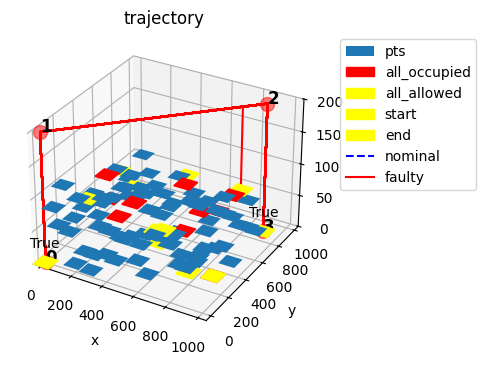

In [23]:
plot_env_with_traj_z(hists , mdl)

In [24]:
statsfmea = tabulate.FMEA(endresults, fs,
                          weight_metrics=['rate'],
                          avg_metrics=['unsafe_flight_time', 'cost', 'repcost',
                                       'landcost', 'body_strikes',
                                       'head_strikes', 'property_restrictions'])
fmeatab = statsfmea.as_table(sort_by="cost")
fmeatab

rate  unsafe_flight_time  \
plan_path     vision_lack_of_detection    5.989583e-03               281.0   
dist_ee       degr                        2.395833e-06               281.0   
              short                       1.437500e-06               281.0   
              break                       9.583333e-07               281.0   
affect_dof    lr_ctlbreak                 9.583333e-07               281.0   
              rf_ctlbreak                 9.583333e-07               281.0   
              lf_ctlbreak                 9.583333e-07               281.0   
              rr_ctlbreak                 9.583333e-07               281.0   
              rr_ctldn                    9.583333e-07               281.0   
              lf_ctlup                    9.583333e-07               281.0   
              rf_ctlup                    9.583333e-07               281.0   
              rr_ctlup                    9.583333e-07               281.0   
              lr_ctlup                    9.583333e-07               281.0   
              lr_ctldn                    9.583333e-07               281.0   
              lf_ctldn                    9.583333e-07               281.0   
              rf_ctldn                    9.583333e-07               281.0   
hold_payload  deform                      2.875000e-09               281.0   
              break                       7.187500e-10               281.0   
affect_dof    rr_mechbreak                4.791667e-07               281.0   
              lf_mechbreak                4.791667e-07               281.0   
              rf_mechbreak                4.791667e-07               281.0   
              lr_mechbreak                4.791667e-07               281.0   
plan_path     degloc                      2.875000e-08               281.0   
ctl_dof       degctl                      2.875000e-08               281.0   
              noctl                       7.187500e-09               281.0   
plan_path     noloc                       7.187500e-09               281.0   
manage_health lostfunction                1.796875e-10               281.0   
affect_dof    lr_openc                    4.791667e-07               281.0   
              lf_openc                    4.791667e-07               281.0   
              rr_short                    4.791667e-07               281.0   
              rr_openc                    4.791667e-07               281.0   
              rf_short                    4.791667e-07               281.0   
              lf_short                    4.791667e-07               281.0   
              lr_short                    4.791667e-07               281.0   
              rf_openc                    4.791667e-07               281.0   
              rr_mechfriction             2.395833e-07               281.0   
              lr_mechfriction             2.395833e-07               281.0   
              lf_mechfriction             2.395833e-07               281.0   
              rf_mechfriction             2.395833e-07               281.0   
              lr_propbreak                1.437500e-07               281.0   
              lf_propbreak                1.437500e-07               281.0   
              rr_propbreak                1.437500e-07               281.0   
              rf_propbreak                1.437500e-07               281.0   
store_ee      lowcharge                   1.677083e-07               281.0   
affect_dof    lr_propstuck                9.583333e-08               281.0   
              rr_propstuck                9.583333e-08               281.0   
              rf_propstuck                9.583333e-08               281.0   
              lf_propstuck                9.583333e-08               281.0   
store_ee      s1p1_nocharge               1.437500e-07               281.0   
affect_dof    lf_propwarp                 4.791667e-08               281.0   
              lr_propwarp                 4.791667e-08               281